In [1]:
import gmsh
import numpy as np
import meshio
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import importlib
from matplotlib.animation import PillowWriter

import functions as func
import Model
import Load

importlib.reload(func)
importlib.reload(Model)

import contextlib
import os
from urllib.request import urlretrieve
from scipy.integrate import solve_ivp
from scipy.sparse import linalg
from scipy.linalg import eigh, eig
from sympy import *
from scipy.sparse import csr_matrix





#### Breakwater parameters

In [2]:
# Domain parameters
global seaside, roof, top, wall, tip
seaside = 10  # Length of the domain in x-direction
roof = 13  # Length of the domain in y-direction (roof of the crownwall)
top = 10 # top of the caisson
wall = 8 # location of the left side of the crownwall
tip = 1 # tip of the crownwall

#### Mesh definition

In [3]:
# Mesh size
lc_big = 5
lc_small = 5

interior_tag, sea_side_tag, bottom_side_tag = Model.Mesh(lc_small, lc_big, seaside, roof, top, wall, tip)

#### Mesh plotting & boundary visualization

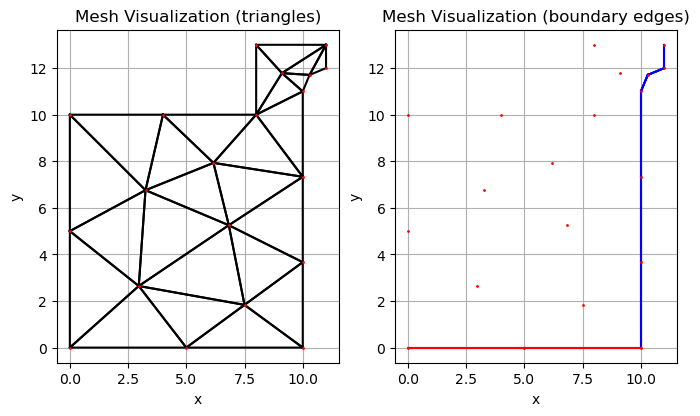

In [4]:
# Read mesh from file
global points, triangles, group_bottom, group_sea, bottom_edges, sea_edges
points, triangles, group_bottom, group_sea, bottom_edges, sea_edges, mesh = Model.form_mesh(bottom_side_tag, sea_side_tag)

# Plot triangles
fig, ax = plt.subplots(1,2, figsize=(8, 8))
for tri in triangles:
    coords = points[tri]
    coords = np.vstack((coords, coords[0]))  # close the triangle
    ax[0].plot(coords[:, 0], coords[:, 1], 'k-')
ax[0].plot(points[:, 0], points[:, 1], 'ro', markersize=1)
ax[0].set_aspect('equal')
ax[0].set_xlabel("x")
ax[0].set_ylabel("y")
ax[0].set_title("Mesh Visualization (triangles)")
ax[0].grid(True)

# Plot edges
for edge in sea_edges:
    coords = points[edge]
    coords = np.vstack((coords, coords[0]))  # close the line
    ax[1].plot(coords[:, 0], coords[:, 1], 'blue', label = "ver")
for edge in bottom_edges:
    coords = points[edge]
    coords = np.vstack((coords, coords[0]))  # close the line
    ax[1].plot(coords[:, 0], coords[:, 1], 'red', label = "hor")
ax[1].plot(points[:, 0], points[:, 1], 'ro', markersize=1)
ax[1].set_aspect('equal')
ax[1].set_xlabel("x")
ax[1].set_ylabel("y")
ax[1].set_title("Mesh Visualization (boundary edges)")
ax[1].grid(True)
plt.show()

#### Generating Load

h1 10 h2 11 d 15
p1 6033.150038621734 p3 22.533045797410832
p1til 0 p2til 37.2825 p3til 82.85


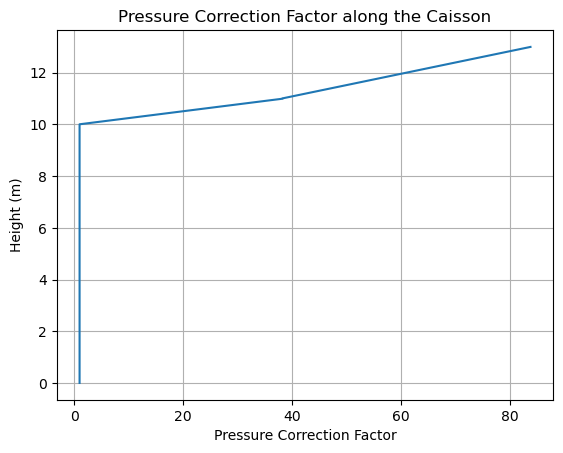

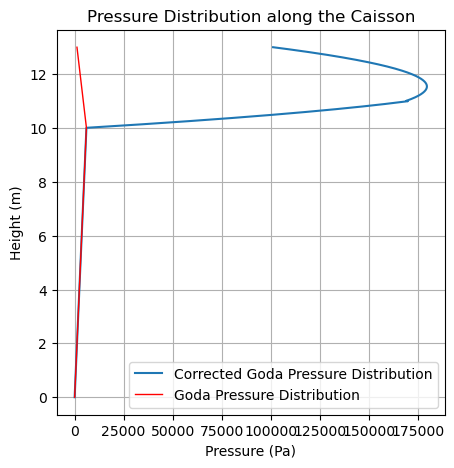

In [5]:
# examples of input values
global H, h, beta, k, h_tot, d, h1, h2
h = 10 # water depth [m]
beta = 2
k = 2 * np.pi / 10  # wave number, assuming a wavelength of 10 m

# Load parameters
H = 1
h_tot = 13 # m
eta = 5 #surface elevation [m] (time dependent)

d = 10 
h1 = h
h2 = 11 # height to start of curvature

goda = Load.goda_original(d, beta, H, eta, k)
q_goda = Load.array_Goda(h_tot, h1, h2, eta, goda, k, H, printing = True)

#### Parameters and boundary condtions

In [6]:
# Problem parameters
E = 36e9  # Young's modulus in Pa
nu = 0.3  # Poisson's ratio
k_bottom = -5000000000
density = 2500  # Density in kg/m^3
body_force = np.array([0, -9.81 * density])  # Body force (gravity)
# body_force = np.array([0, 0])  # Body force (gravity)
C = func.elasticity_tensor(E, nu)
Force = 1
load = q_goda

K, M, f = Model.BC(mesh, triangles, points, C, density, body_force, bottom_edges, sea_edges, k_bottom, roof, load)



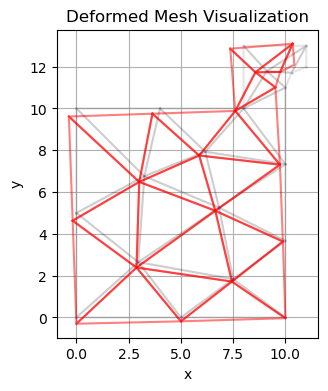

In [7]:
# Solve the system of equations
u = np.linalg.solve(K, f)

# Reshape the solution vector into a 2D array for visualization and magnify by 1e3
u_reshaped = u.reshape(-1, 2) * 1e3


# Plot the deformed mesh
plt.figure(figsize=(8, 4))
for tri in triangles:
    coords = points[tri]
    coords_displaced = coords + u_reshaped[tri]
    coords = np.vstack((coords, coords[0]))  # close the triangle
    coords_displaced = np.vstack((coords_displaced, coords_displaced[0]))  # close the triangle
    plt.plot(coords[:, 0], coords[:, 1], 'k-', alpha=0.1)
    plt.plot(coords_displaced[:,0],coords_displaced[:,1], 'r-', alpha=0.5)
plt.plot(points[:, 0], points[:, 1], 'bo', markersize=1, alpha =0.1)
plt.gca().set_aspect('equal')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Deformed Mesh Visualization")
plt.grid(True)
plt.show()

#### Central difference method

In [8]:
K_cd = csr_matrix(K)
M_cd = csr_matrix(M)

dt = 0.3 # timestep
T = 20 # total time
time_steps = np.arange(0, T, dt)
beta = 1/4
gamma = 1/2

In [ ]:
amplification = 1000

u_hist = Model.time_discretization(amplification, f, K_cd, M_cd, time_steps, dt, gamma, beta)


In [ ]:
importlib.reload(Model)
Model.plot_all(time_steps, u_hist, points)

In [ ]:
# Setup plot

fig, ax = plt.subplots(figsize=(6, 6))
sc = ax.scatter(points[:, 0], points[:, 1], c='blue', s=10, alpha = 0.1)
ax.set_xlim(points[:, 0].min() - 2, points[:, 0].max() + 2)
ax.set_ylim(points[:, 1].min() - 2, points[:, 1].max() + 2)
ax.set_title("Structure Deformation Over Time")
ax.set_aspect('equal')

for i in range(len(time_steps)):
    deform = points + u_hist[i]
    ax.scatter(deform[:, 0], deform[:, 1], s=10, alpha=0.2)


ax.legend()

plt.show()